In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
from keras.callbacks import History 
#using tensorflow backend

Using TensorFlow backend.


In [3]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [4]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [5]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [6]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [7]:
def sum_last14(casos_por_dia):
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [8]:
def predict_cases(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the predictions and cases per day
    predicts cases per day after calculating the risk diagram, using the empirical reproductive
    ratio given by rep_fun
    """
    prox_dia = max(fecha_sintomas)+1
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    valid_days = np.arange(19,prox_dia+6,1)
    casos_por_dia = sum_last14(casos_por_dia) #gets all active cases in the last 14-days 
    if graph == True:
        plt.style.use('ggplot')
        plt.xlabel('Dias desde el comienzo')
        plt.ylabel('Infectados activos en BRC')
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',markersize=4,label="casos hasta dia: "+str(prox_dia))
        plt.plot(valid_days,p_t,linewidth=3,label='prediccion')
        plt.legend()
        #plt.savefig('9oct_predic_casos.pdf')
    if ret == True:
        error_global = np.linalg.norm(casos_por_dia[19:,1]-p_t[:-6])
        return error_global

In [9]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)

In [10]:
data = pd.read_csv("casos/casos_Bariloche.txt",sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
df = pd.DataFrame(data) #converting to dataframe for use

In [11]:
inicio_epidemia = min(df["fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df["fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-03-09 00:00:00
ultimo sintoma de persona confirmada:  2020-12-18 00:00:00
ultima apertura de persona confirmada:  2020-12-20 00:00:00


In [12]:
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
fecha_sintomas = fecha_sintomas.astype(int)
fecha_sintomas[fecha_sintomas < 0] = 1

In [13]:
a = np.zeros(6) + 1
pop = 100000
rep_fun = repratio_t_conv
r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
a_t = a_t[13:]
a_t[a_t.shape[0]-7:] = 0
a = np.zeros(a_t.shape[0]+10)
a[:a_t.shape[0]] = a_t

In [14]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
casos_por_dia = sum_last14(casos_por_dia)
casos_por_dia = casos_por_dia[20:,1]
b = np.zeros(a_t.shape[0]+10)
b[:casos_por_dia.shape[0]] = casos_por_dia
b = b.reshape(b.shape[0],1)

In [15]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
n_t = np.copy(casos_por_dia)
prox_dia = max(fecha_sintomas) + 1
#completing the values for the rest of the values of n_t
aux = np.zeros(2)
i = 0
while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
    aux[0] = prox_dia + i
    aux[1] = np.mean(n_t[prox_dia-7:,1])
    n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
    i= i +1
dias = np.copy(n_t[:,0]).astype(int)
dias = dias[:-1]
m1 = np.zeros((dias[dias>=6].shape[0],3)) #denominator of r7 expression
m2 = np.zeros((dias[dias>=6].shape[0],3)) #numerator of r7 expression

In [16]:
for i in dias[dias>=6]:
    m1[i-6,:] = n_t[i-6:i-3,1]
    m2[i-6,:] = n_t[i-1:i+2,1]

In [17]:
n_dias = m1.shape[0]

In [18]:
def my_matrix(shape):
    n_dias = shape
    m = np.zeros((n_dias,n_dias))
    i = 0
    while i < n_dias - 7:
        m[i,i:i+7] = 1/7
        i = i + 1
    return m

In [19]:
m1 = m1[75:,:]
m2 = m2[75:,:]
n_dias = m1.shape[0]
a = a[75:]
b = b[75:]

In [20]:
numpyA = my_matrix(n_dias)
numpyA = keras.backend.variable(numpyA)
mat = numpyA

In [39]:
input_1 = keras.layers.Input(shape=(3,))
input_2 = keras.layers.Input(shape=(3,))
input_3 = keras.layers.Input(shape=(1,))
initializer = keras.initializers.Ones() #the vector of weights a
initializer_2 = keras.initializers.Ones()
l_input_1 = keras.layers.Dense(1,activation='relu',kernel_initializer=initializer_2,use_bias=False)(input_1)
l_input_2 = keras.layers.Dense(1,activation='relu',use_bias=False,kernel_initializer=initializer,trainable=False)(input_2)
division = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] != 0, inputs[1]/inputs[0], inputs[1]))([l_input_1, l_input_2])#calculates empirical rt
#max_limit = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] > 4,4*inputs[1]/inputs[0], inputs[1]))([division,division]) #limit output to max of 4 for rt
mean = keras.layers.Lambda(lambda x: keras.backend.dot(mat,x))(division) #calculates mean r_seven in seven days
cases = keras.layers.Multiply()([input_3,mean]) #cases for valid prediction,net output, padded with zeros at the end
model = keras.Model(inputs=[input_1,input_2,input_3], outputs=cases)
model.compile(optimizer='nadam', loss=keras.losses.MSE, metrics=['mse'])
history = model.fit([m1,m2,a], b, epochs=1000, batch_size=n_dias)
model.summary()

Epoch 1/1000
207/207 [==============================] - 0s 272us/step - loss: 52424.2070 - mse: 52424.2070
Epoch 2/1000
207/207 [==============================] - 0s 14us/step - loss: 58754.6562 - mse: 58754.6562
Epoch 3/1000
207/207 [==============================] - 0s 14us/step - loss: 48294.2461 - mse: 48294.2461
Epoch 4/1000
207/207 [==============================] - 0s 15us/step - loss: 54624.5586 - mse: 54624.5586
Epoch 5/1000
207/207 [==============================] - 0s 14us/step - loss: 43627.1094 - mse: 43627.1094
Epoch 6/1000
207/207 [==============================] - 0s 14us/step - loss: 45259.2812 - mse: 45259.2812
Epoch 7/1000
207/207 [==============================] - 0s 10us/step - loss: 49298.9688 - mse: 49298.9727
Epoch 8/1000
207/207 [==============================] - 0s 14us/step - loss: 62802.7734 - mse: 62802.7734
Epoch 9/1000
207/207 [==============================] - 0s 14us/step - loss: 46919.8945 - mse: 46919.8945
Epoch 10/1000
207/207 [======================

Epoch 78/1000
207/207 [==============================] - 0s 14us/step - loss: 35169.4883 - mse: 35169.4883
Epoch 79/1000
207/207 [==============================] - 0s 10us/step - loss: 53538.0469 - mse: 53538.0469
Epoch 80/1000
207/207 [==============================] - 0s 14us/step - loss: 36471.7852 - mse: 36471.7891
Epoch 81/1000
207/207 [==============================] - 0s 14us/step - loss: 38569.7305 - mse: 38569.7305
Epoch 82/1000
207/207 [==============================] - 0s 10us/step - loss: 35345.4375 - mse: 35345.4414
Epoch 83/1000
207/207 [==============================] - 0s 19us/step - loss: 44784.6367 - mse: 44784.6367
Epoch 84/1000
207/207 [==============================] - 0s 14us/step - loss: 56473.1289 - mse: 56473.1289
Epoch 85/1000
207/207 [==============================] - 0s 10us/step - loss: 32790.3203 - mse: 32790.3203
Epoch 86/1000
207/207 [==============================] - 0s 10us/step - loss: 49190.8047 - mse: 49190.8086
Epoch 87/1000
207/207 [==============

Epoch 155/1000
207/207 [==============================] - 0s 10us/step - loss: 31600.5898 - mse: 31600.5898
Epoch 156/1000
207/207 [==============================] - 0s 10us/step - loss: 38303.0781 - mse: 38303.0781
Epoch 157/1000
207/207 [==============================] - 0s 14us/step - loss: 40978.5195 - mse: 40978.5234
Epoch 158/1000
207/207 [==============================] - 0s 14us/step - loss: 41669.1992 - mse: 41669.1992
Epoch 159/1000
207/207 [==============================] - 0s 14us/step - loss: 37595.6172 - mse: 37595.6172
Epoch 160/1000
207/207 [==============================] - 0s 10us/step - loss: 38460.9062 - mse: 38460.9062
Epoch 161/1000
207/207 [==============================] - 0s 14us/step - loss: 38725.4844 - mse: 38725.4844
Epoch 162/1000
207/207 [==============================] - 0s 10us/step - loss: 36096.5586 - mse: 36096.5586
Epoch 163/1000
207/207 [==============================] - 0s 10us/step - loss: 27895.0488 - mse: 27895.0488
Epoch 164/1000
207/207 [====

Epoch 231/1000
207/207 [==============================] - 0s 14us/step - loss: 40456.1602 - mse: 40456.1602
Epoch 232/1000
207/207 [==============================] - 0s 14us/step - loss: 43907.7852 - mse: 43907.7891
Epoch 233/1000
207/207 [==============================] - 0s 10us/step - loss: 35792.5469 - mse: 35792.5469
Epoch 234/1000
207/207 [==============================] - 0s 10us/step - loss: 34383.2930 - mse: 34383.2930
Epoch 235/1000
207/207 [==============================] - 0s 14us/step - loss: 38520.5156 - mse: 38520.5156
Epoch 236/1000
207/207 [==============================] - 0s 14us/step - loss: 29690.8086 - mse: 29690.8086
Epoch 237/1000
207/207 [==============================] - 0s 10us/step - loss: 36559.6172 - mse: 36559.6172
Epoch 238/1000
207/207 [==============================] - 0s 10us/step - loss: 30383.1562 - mse: 30383.1562
Epoch 239/1000
207/207 [==============================] - 0s 14us/step - loss: 38525.6289 - mse: 38525.6289
Epoch 240/1000
207/207 [====

Epoch 307/1000
207/207 [==============================] - 0s 14us/step - loss: 50007.5391 - mse: 50007.5430
Epoch 308/1000
207/207 [==============================] - 0s 14us/step - loss: 48734.5547 - mse: 48734.5547
Epoch 309/1000
207/207 [==============================] - 0s 10us/step - loss: 44391.9414 - mse: 44391.9414
Epoch 310/1000
207/207 [==============================] - 0s 14us/step - loss: 36781.3047 - mse: 36781.3047
Epoch 311/1000
207/207 [==============================] - 0s 14us/step - loss: 37924.0977 - mse: 37924.0977
Epoch 312/1000
207/207 [==============================] - 0s 10us/step - loss: 46931.9414 - mse: 46931.9414
Epoch 313/1000
207/207 [==============================] - 0s 14us/step - loss: 31071.0820 - mse: 31071.0820
Epoch 314/1000
207/207 [==============================] - 0s 10us/step - loss: 37999.3750 - mse: 37999.3750
Epoch 315/1000
207/207 [==============================] - 0s 14us/step - loss: 33771.0234 - mse: 33771.0234
Epoch 316/1000
207/207 [====

Epoch 383/1000
207/207 [==============================] - 0s 14us/step - loss: 36927.4688 - mse: 36927.4688
Epoch 384/1000
207/207 [==============================] - 0s 10us/step - loss: 38099.3477 - mse: 38099.3477
Epoch 385/1000
207/207 [==============================] - 0s 10us/step - loss: 29986.3203 - mse: 29986.3203
Epoch 386/1000
207/207 [==============================] - 0s 10us/step - loss: 41549.3125 - mse: 41549.3125
Epoch 387/1000
207/207 [==============================] - 0s 10us/step - loss: 35885.6992 - mse: 35885.6992
Epoch 388/1000
207/207 [==============================] - 0s 10us/step - loss: 46180.2695 - mse: 46180.2695
Epoch 389/1000
207/207 [==============================] - 0s 10us/step - loss: 41835.6406 - mse: 41835.6406
Epoch 390/1000
207/207 [==============================] - 0s 10us/step - loss: 33972.8047 - mse: 33972.8086
Epoch 391/1000
207/207 [==============================] - 0s 10us/step - loss: 36316.5273 - mse: 36316.5273
Epoch 392/1000
207/207 [====

Epoch 459/1000
207/207 [==============================] - 0s 10us/step - loss: 40102.0820 - mse: 40102.0820
Epoch 460/1000
207/207 [==============================] - 0s 14us/step - loss: 44088.1250 - mse: 44088.1250
Epoch 461/1000
207/207 [==============================] - 0s 10us/step - loss: 48353.5586 - mse: 48353.5586
Epoch 462/1000
207/207 [==============================] - 0s 10us/step - loss: 41643.8438 - mse: 41643.8438
Epoch 463/1000
207/207 [==============================] - 0s 10us/step - loss: 39145.0586 - mse: 39145.0586
Epoch 464/1000
207/207 [==============================] - 0s 14us/step - loss: 31417.7578 - mse: 31417.7578
Epoch 465/1000
207/207 [==============================] - 0s 9us/step - loss: 48292.5977 - mse: 48292.5977
Epoch 466/1000
207/207 [==============================] - 0s 10us/step - loss: 36806.6719 - mse: 36806.6719
Epoch 467/1000
207/207 [==============================] - 0s 14us/step - loss: 37718.9609 - mse: 37718.9609
Epoch 468/1000
207/207 [=====

Epoch 535/1000
207/207 [==============================] - 0s 10us/step - loss: 40892.5586 - mse: 40892.5586
Epoch 536/1000
207/207 [==============================] - 0s 14us/step - loss: 37507.8672 - mse: 37507.8711
Epoch 537/1000
207/207 [==============================] - 0s 10us/step - loss: 35854.8320 - mse: 35854.8320
Epoch 538/1000
207/207 [==============================] - 0s 10us/step - loss: 42200.9062 - mse: 42200.9102
Epoch 539/1000
207/207 [==============================] - 0s 14us/step - loss: 24819.2090 - mse: 24819.2109
Epoch 540/1000
207/207 [==============================] - 0s 14us/step - loss: 35309.4727 - mse: 35309.4727
Epoch 541/1000
207/207 [==============================] - 0s 10us/step - loss: 34508.8555 - mse: 34508.8555
Epoch 542/1000
207/207 [==============================] - 0s 10us/step - loss: 34837.5938 - mse: 34837.5938
Epoch 543/1000
207/207 [==============================] - 0s 14us/step - loss: 39667.9453 - mse: 39667.9453
Epoch 544/1000
207/207 [====

Epoch 611/1000
207/207 [==============================] - 0s 10us/step - loss: 41721.5664 - mse: 41721.5664
Epoch 612/1000
207/207 [==============================] - 0s 14us/step - loss: 28310.6074 - mse: 28310.6094
Epoch 613/1000
207/207 [==============================] - 0s 10us/step - loss: 42187.4102 - mse: 42187.4102
Epoch 614/1000
207/207 [==============================] - 0s 15us/step - loss: 35882.0508 - mse: 35882.0547
Epoch 615/1000
207/207 [==============================] - 0s 10us/step - loss: 31809.4531 - mse: 31809.4551
Epoch 616/1000
207/207 [==============================] - 0s 19us/step - loss: 47773.4570 - mse: 47773.4570
Epoch 617/1000
207/207 [==============================] - 0s 10us/step - loss: 40783.8359 - mse: 40783.8359
Epoch 618/1000
207/207 [==============================] - 0s 14us/step - loss: 48972.1328 - mse: 48972.1367
Epoch 619/1000
207/207 [==============================] - 0s 10us/step - loss: 39188.3086 - mse: 39188.3086
Epoch 620/1000
207/207 [====

Epoch 687/1000
207/207 [==============================] - 0s 14us/step - loss: 30534.1113 - mse: 30534.1113
Epoch 688/1000
207/207 [==============================] - 0s 10us/step - loss: 42696.7383 - mse: 42696.7383
Epoch 689/1000
207/207 [==============================] - 0s 14us/step - loss: 28841.0742 - mse: 28841.0742
Epoch 690/1000
207/207 [==============================] - 0s 14us/step - loss: 38435.8047 - mse: 38435.8086
Epoch 691/1000
207/207 [==============================] - 0s 10us/step - loss: 35004.7852 - mse: 35004.7891
Epoch 692/1000
207/207 [==============================] - 0s 14us/step - loss: 35578.5898 - mse: 35578.5898
Epoch 693/1000
207/207 [==============================] - 0s 10us/step - loss: 36817.8359 - mse: 36817.8359
Epoch 694/1000
207/207 [==============================] - 0s 10us/step - loss: 39251.4688 - mse: 39251.4688
Epoch 695/1000
207/207 [==============================] - 0s 10us/step - loss: 35639.1719 - mse: 35639.1758
Epoch 696/1000
207/207 [====

Epoch 763/1000
207/207 [==============================] - 0s 10us/step - loss: 39828.5508 - mse: 39828.5508
Epoch 764/1000
207/207 [==============================] - 0s 14us/step - loss: 37381.4453 - mse: 37381.4453
Epoch 765/1000
207/207 [==============================] - 0s 10us/step - loss: 30459.8809 - mse: 30459.8809
Epoch 766/1000
207/207 [==============================] - 0s 10us/step - loss: 56535.4102 - mse: 56535.4102
Epoch 767/1000
207/207 [==============================] - 0s 10us/step - loss: 42854.2305 - mse: 42854.2305
Epoch 768/1000
207/207 [==============================] - 0s 14us/step - loss: 45678.3477 - mse: 45678.3477
Epoch 769/1000
207/207 [==============================] - 0s 14us/step - loss: 38951.5352 - mse: 38951.5352
Epoch 770/1000
207/207 [==============================] - 0s 10us/step - loss: 25072.3926 - mse: 25072.3945
Epoch 771/1000
207/207 [==============================] - 0s 10us/step - loss: 43290.8516 - mse: 43290.8516
Epoch 772/1000
207/207 [====

Epoch 839/1000
207/207 [==============================] - 0s 10us/step - loss: 30891.5352 - mse: 30891.5371
Epoch 840/1000
207/207 [==============================] - 0s 10us/step - loss: 45813.6914 - mse: 45813.6914
Epoch 841/1000
207/207 [==============================] - 0s 14us/step - loss: 34169.0625 - mse: 34169.0625
Epoch 842/1000
207/207 [==============================] - 0s 10us/step - loss: 38463.1055 - mse: 38463.1055
Epoch 843/1000
207/207 [==============================] - 0s 14us/step - loss: 29673.8320 - mse: 29673.8340
Epoch 844/1000
207/207 [==============================] - 0s 10us/step - loss: 38008.5664 - mse: 38008.5664
Epoch 845/1000
207/207 [==============================] - 0s 14us/step - loss: 28190.0195 - mse: 28190.0195
Epoch 846/1000
207/207 [==============================] - 0s 14us/step - loss: 40068.8555 - mse: 40068.8555
Epoch 847/1000
207/207 [==============================] - 0s 10us/step - loss: 32712.6133 - mse: 32712.6133
Epoch 848/1000
207/207 [====

Epoch 915/1000
207/207 [==============================] - 0s 10us/step - loss: 44372.6836 - mse: 44372.6875
Epoch 916/1000
207/207 [==============================] - 0s 14us/step - loss: 34371.3203 - mse: 34371.3203
Epoch 917/1000
207/207 [==============================] - 0s 10us/step - loss: 40134.2305 - mse: 40134.2305
Epoch 918/1000
207/207 [==============================] - 0s 10us/step - loss: 52267.9883 - mse: 52267.9922
Epoch 919/1000
207/207 [==============================] - 0s 10us/step - loss: 30979.6309 - mse: 30979.6309
Epoch 920/1000
207/207 [==============================] - 0s 14us/step - loss: 44238.7188 - mse: 44238.7188
Epoch 921/1000
207/207 [==============================] - 0s 14us/step - loss: 36724.1719 - mse: 36724.1758
Epoch 922/1000
207/207 [==============================] - 0s 10us/step - loss: 40033.2812 - mse: 40033.2812
Epoch 923/1000
207/207 [==============================] - 0s 14us/step - loss: 50814.5391 - mse: 50814.5430
Epoch 924/1000
207/207 [====

Epoch 991/1000
207/207 [==============================] - 0s 14us/step - loss: 35743.4336 - mse: 35743.4336
Epoch 992/1000
207/207 [==============================] - 0s 10us/step - loss: 45802.9336 - mse: 45802.9336
Epoch 993/1000
207/207 [==============================] - 0s 14us/step - loss: 45823.0820 - mse: 45823.0820
Epoch 994/1000
207/207 [==============================] - 0s 10us/step - loss: 28751.3418 - mse: 28751.3438
Epoch 995/1000
207/207 [==============================] - 0s 14us/step - loss: 30598.9629 - mse: 30598.9629
Epoch 996/1000
207/207 [==============================] - 0s 13us/step - loss: 40473.2344 - mse: 40473.2383
Epoch 997/1000
207/207 [==============================] - 0s 14us/step - loss: 34041.8750 - mse: 34041.8750
Epoch 998/1000
207/207 [==============================] - 0s 10us/step - loss: 34991.9258 - mse: 34991.9258
Epoch 999/1000
207/207 [==============================] - 0s 14us/step - loss: 43116.9570 - mse: 43116.9570
Epoch 1000/1000
207/207 [===

In [40]:
first_layer_weights = model.layers[2].get_weights()
second_layer_weights = model.layers[3].get_weights()
print(first_layer_weights,second_layer_weights)

[array([[0.98908496],
       [1.2436355 ],
       [1.2353151 ]], dtype=float32)] [array([[1.],
       [1.],
       [1.]], dtype=float32)]


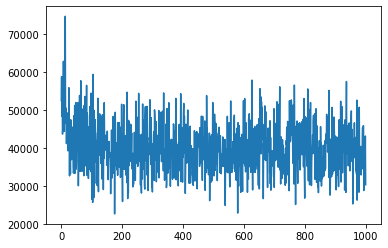

In [41]:
plt.plot(history.history['loss'])